In [460]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SelectKBest, chi2, f_regression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

In [461]:
#import dataframe
df_ch = pd.read_csv("company_hierarchy.csv")
df_ch.head()

,employee_id,boss_id,dept
0,46456,175361.0,sales
1,104708,29733.0,HR
2,120853,41991.0,sales
3,142630,171266.0,HR
4,72711,198240.0,sales


In [462]:
#import second dataframe
df_e = pd.read_csv("employee.csv")
df_e.head()

,employee_id,signing_bonus,salary,degree_level,sex,yrs_experience
0,138719,0,273000.0,Master,M,2
1,3192,0,301000.0,Bachelor,F,1
2,114657,0,261000.0,Master,F,2
3,29039,0,86000.0,High_School,F,4
4,118607,0,126000.0,Bachelor,F,3


In [463]:
df_ch.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   employee_id  10000 non-null  int64  
 1   boss_id      9999 non-null   float64
 2   dept         10000 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


In [464]:
df_e.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   employee_id     10000 non-null  int64  
 1   signing_bonus   10000 non-null  int64  
 2   salary          10000 non-null  float64
 3   degree_level    10000 non-null  object 
 4   sex             10000 non-null  object 
 5   yrs_experience  10000 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 468.9+ KB


both datasets have 1000 entries, and a column labeled employee_id so I'll merge these two datasets to make it easier to handle. Also, all column types are what I want them to be so no need to make any changes there. It looks like there's at least one missing data from boss_id but we'll see what happens after we combine the two

In [465]:
#join the two datasets on employee_id
df=pd.merge(left=df_ch, right=df_e, how='left', on='employee_id')
df.head()

,employee_id,boss_id,dept,signing_bonus,salary,degree_level,sex,yrs_experience
0,46456,175361.0,sales,0,213000.0,Bachelor,M,5
1,104708,29733.0,HR,0,79000.0,Bachelor,F,3
2,120853,41991.0,sales,0,199000.0,High_School,M,5
3,142630,171266.0,HR,0,143000.0,PhD,F,13
4,72711,198240.0,sales,0,235000.0,Master,M,1


In [466]:
#looking at percentages for missing data
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
print(missing)

                Total  Percent
boss_id             1   0.0001
employee_id         0   0.0000
dept                0   0.0000
signing_bonus       0   0.0000
salary              0   0.0000
degree_level        0   0.0000
sex                 0   0.0000
yrs_experience      0   0.0000


Only one entry missing from the boss_id. Let's take a look at this to see if it's important

In [467]:
#printing the rows of missing data
missing_data_rows = df[df.isnull().any(axis=1)]
print(missing_data_rows)

      employee_id  boss_id dept  signing_bonus    salary degree_level sex  \
2427        61554      NaN  CEO              1  700000.0          PhD   M   

      yrs_experience  
2427               7  


The one person missing a boss_id is the CEO. This makes sense, since the CEO isn't going to have a boss in this scenario, so his boss_id will be blank. I'm leaving this missing data without making any changes. 

In [468]:
df.describe()

,employee_id,boss_id,signing_bonus,salary,yrs_experience
count,10000.000000,9999.000000,10000.000000,10000.000000,10000.000000
mean,100001.855800,103299.980498,0.301400,189111.800000,3.875200
std,57500.488641,57508.798817,0.458889,88973.796898,3.107409
min,40.000000,79.000000,0.000000,60000.000000,1.000000
25%,50574.500000,55883.000000,0.000000,110000.000000,2.000000
50%,99244.500000,102712.000000,0.000000,182000.000000,3.000000
75%,149748.500000,152288.000000,1.000000,255000.000000,5.000000
max,199956.000000,199950.000000,1.000000,700000.000000,34.000000


medium number of years is 3.8, with a standard deviation of 3.8 years, and the max is 34 years. the mean salary is $189,111 with the standard deviation being $88,973. Next I'm going to create a new column that includes each person's level within the company

In [469]:
#employee id is the only column that we don't want to see duplicates for. These should all be unique numbers. 
duplicates = df['employee_id'].duplicated().any()
print(duplicates)

False


In [470]:
# Set everyone as "IC" initially
df['level'] = "IC"

In [471]:
# Identify the CEO and update their level
df.loc[df.dept == "CEO", "level"] = "CEO"

In [472]:
# Define company levels order
company_levels = ["CEO", "E", "VP", "D", "MM"]

In [473]:
# First, create a mapping for levels to their bosses
for i in range(1, len(company_levels)):
    # Get the employee IDs of the level above
    boss_ids = df.loc[df.level == company_levels[i-1], 'employee_id']
    
    # Update the levels of employees whose boss is at the current boss_id
    df.loc[df.boss_id.isin(boss_ids), 'level'] = company_levels[i]

#Check count of each level
print(df['level'].value_counts())

level
IC     9000
MM      800
D       160
VP       35
E         4
CEO       1
Name: count, dtype: int64


Now that we have everyone's level set up, I'm going to find out the number of people that each person manages

In [474]:
#create a new column and set all employees to 0
df['total_reports'] = 0

In [475]:
#created a function to find out the number of people that an employee is in charge of

def calculate_total_reports(df):
    # dictionary to store the number of direct reported people for each employee
    direct_reports = df.groupby('boss_id')['employee_id'].apply(list).to_dict()
    
    # set the total reports for each employee to 0
    total_reports = {employee: 0 for employee in df['employee_id'].unique()}
    
    def count_reports(employee):
        # If the employee already has their total reports calculated, return the value
        if total_reports[employee] > 0:
            return total_reports[employee]
        
        num_reports = len(direct_reports.get(employee, []))
        
        # count the reports of each report
        for report in direct_reports.get(employee, []):
            num_reports += count_reports(report)
        
        # Store the total reports count for the employee
        total_reports[employee] = num_reports
        return num_reports

    # Apply the counting function to all employees
    for employee in df['employee_id'].unique():
        count_reports(employee)

    # Update the DataFrame with the total reports for each employee
    df['total_reports'] = df['employee_id'].map(total_reports)
    
    return df

# Calculate the total reports for each employee
df = calculate_total_reports(df)

In [476]:
#going to print the highest number of reports to make sure the CEO is 9999 since everyone else in the company should be working under him
top_employees = df[['employee_id', 'boss_id', 'level', 'total_reports']].sort_values(by='total_reports', ascending=False)

print(top_employees.head())

      employee_id  boss_id level  total_reports
2427        61554      NaN   CEO           9999
1310        11277  61554.0     E           3598
2778        51535  61554.0     E           2695
1009       110464  61554.0     E           2009
9640        93708  61554.0     E           1693


In [477]:
#checking to see if there are any negative values for these columns since there shouldn't be
salary_negative = (df['salary'] < 0).any()
bonus_negative = (df['signing_bonus'] < 0).any()
years_negative = (df['yrs_experience'] < 0).any()

print(f"Does 'salary' have negative values? {salary_negative}")
print(f"Does 'bonus' have negative values? {bonus_negative}")
print(f"Does 'years' have negative values? {years_negative}")

Does 'salary' have negative values? False
Does 'bonus' have negative values? False
Does 'years' have negative values? False


Since there is only one CEO who makes much more money than everyone else and there is only one position available (so it would always be either 100% male or female), this would greatly screw our data. So, I'm going to remove outliers from the data before proceeding. 

In [478]:
#function to remove outliers
def remove_outliers_iqr(df, factor=1.5):
  
    Q1 = df['salary'].quantile(0.25)  # 25th percentile
    Q3 = df['salary'].quantile(0.75)  # 75th percentile
    IQR = Q3 - Q1  # Interquartile range

    # Calculate the lower and upper bounds
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
  
    # Print the bounds for debugging
    print(f"Lower Bound (Factor {factor}): \n{lower_bound}")
    print(f"Upper Bound (Factor {factor}): \n{upper_bound}")

    # Filter out the rows where the 'salary' value is outside the bounds
    df_no_outliers = df[(df['salary'] >= lower_bound) & (df['salary'] <= upper_bound)]
  
    return df_no_outliers

df_no = remove_outliers_iqr(df, factor=1.0)
# Check the shape of the data
print(f"Original shape: {df.shape}")
print(f"Shape after removing salary outliers: {df_no.shape}")


Lower Bound (Factor 1.0): 
-35000.0
Upper Bound (Factor 1.0): 
400000.0
Original shape: (10000, 10)
Shape after removing salary outliers: (9995, 10)


According to this, only five employees had outlier salaries, probably including the CEO. This will prevent us from needing to fix any nan values since he was the only one with nan. So, let's see what the data looks like without those employees. 

In [479]:
#setting up color palette
color_palette = ['firebrick', 'royalblue', 'mediumseagreen']

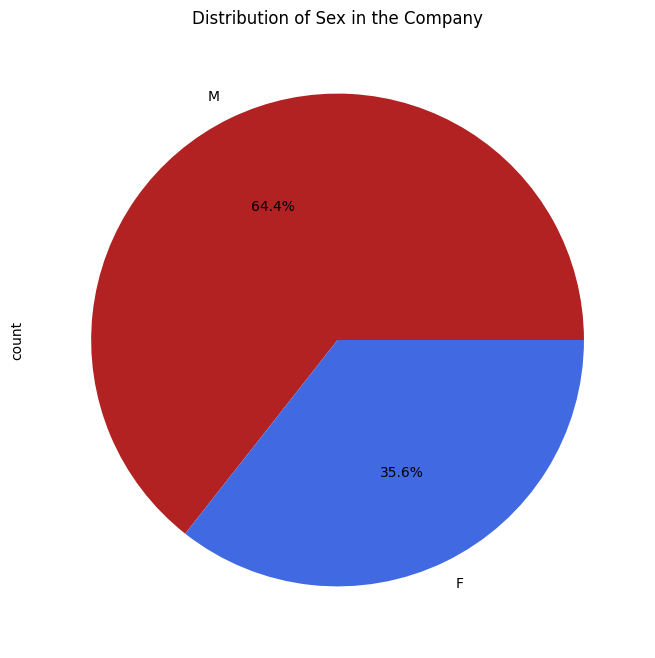

In [480]:
# Count the number of females versus males
counts = df['sex'].value_counts()

# Create the pie chart
plt.figure(figsize=(15,8))
plt.title("Distribution of Sex in the Company")
counts.plot.pie(autopct='%1.1f%%', colors= color_palette)
plt.show()

From this pie chart we can clearly see that there are many more males versus femaels in the company overall

C:\Users\brean\AppData\Local\Temp\ipykernel_7964\3076363740.py:6: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  ax = sns.barplot(x='dept', y='salary', hue='sex', data=df_no, palette=color_palette)


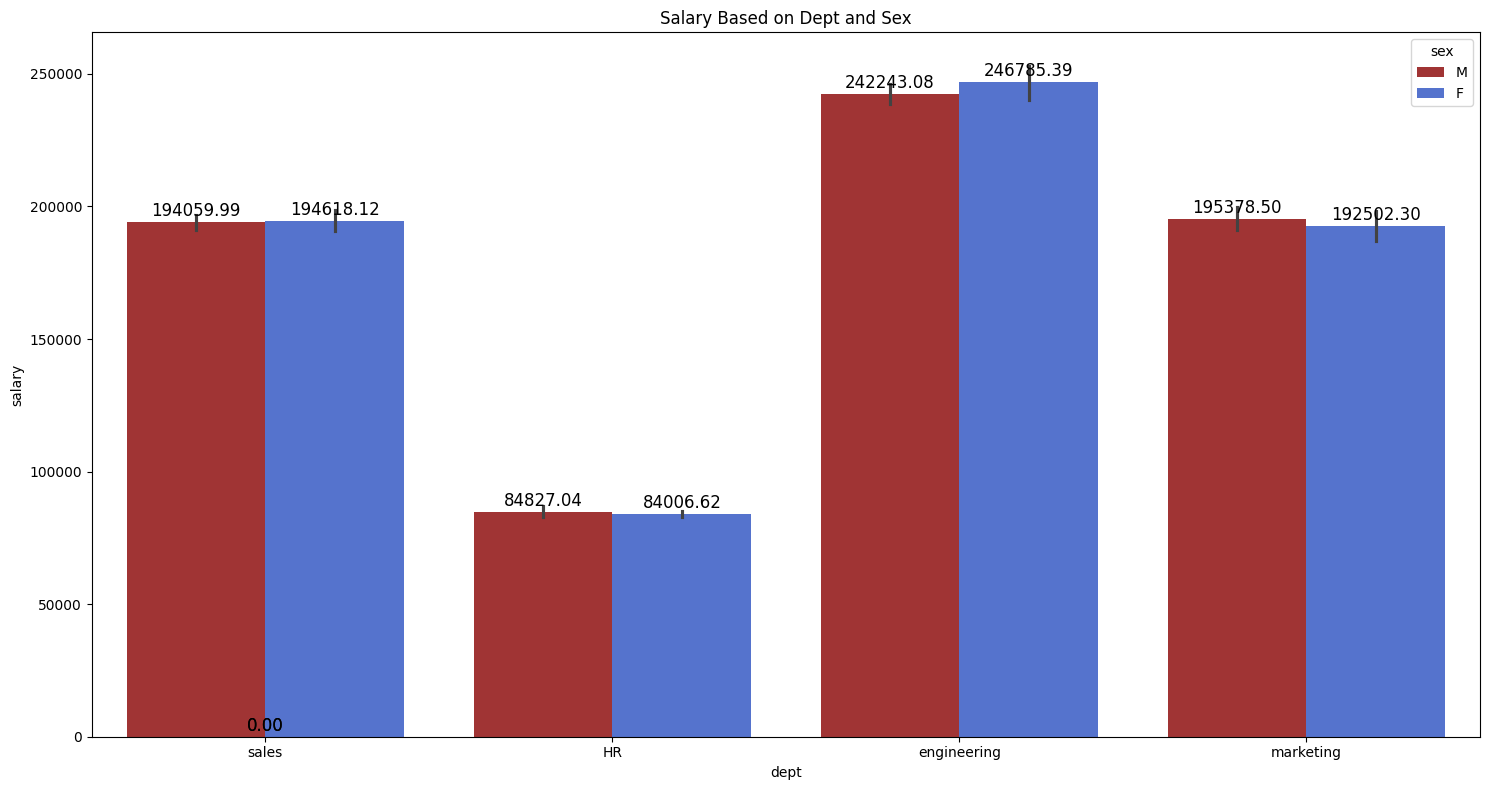

In [481]:
#graph looking at salary, sex, and dept

plt.figure(figsize=(15,8))
plt.title("Salary Based on Dept and Sex")

ax = sns.barplot(x='dept', y='salary', hue='sex', data=df_no, palette=color_palette)

# Add the average salary on each bar
for p in ax.patches:
    # Get the height of each bar (salary value)
    height = p.get_height()
    
    # Get the position where the label will appear
    x_position = p.get_x() + p.get_width() / 2
    
    # Display the value (average salary) on top of the bar
    ax.annotate(f'{height:.2f}', 
                (x_position, height), 
                ha='center', va='center', 
                fontsize=12, color='black', 
                xytext=(0, 8), textcoords='offset points')

plt.tight_layout()
plt.show()


From this graph we see that females make roughly the same amount as males, generally. There is a slight increase in engineering, and sale, and a slight decrease in marketing and HR. 

C:\Users\brean\AppData\Local\Temp\ipykernel_7964\3317489505.py:4: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.violinplot(x ="degree_level", y ="salary", data = df_no, hue = 'sex', palette=color_palette)


<Axes: title={'center': 'Salary based on education and sex'}, xlabel='degree_level', ylabel='salary'>

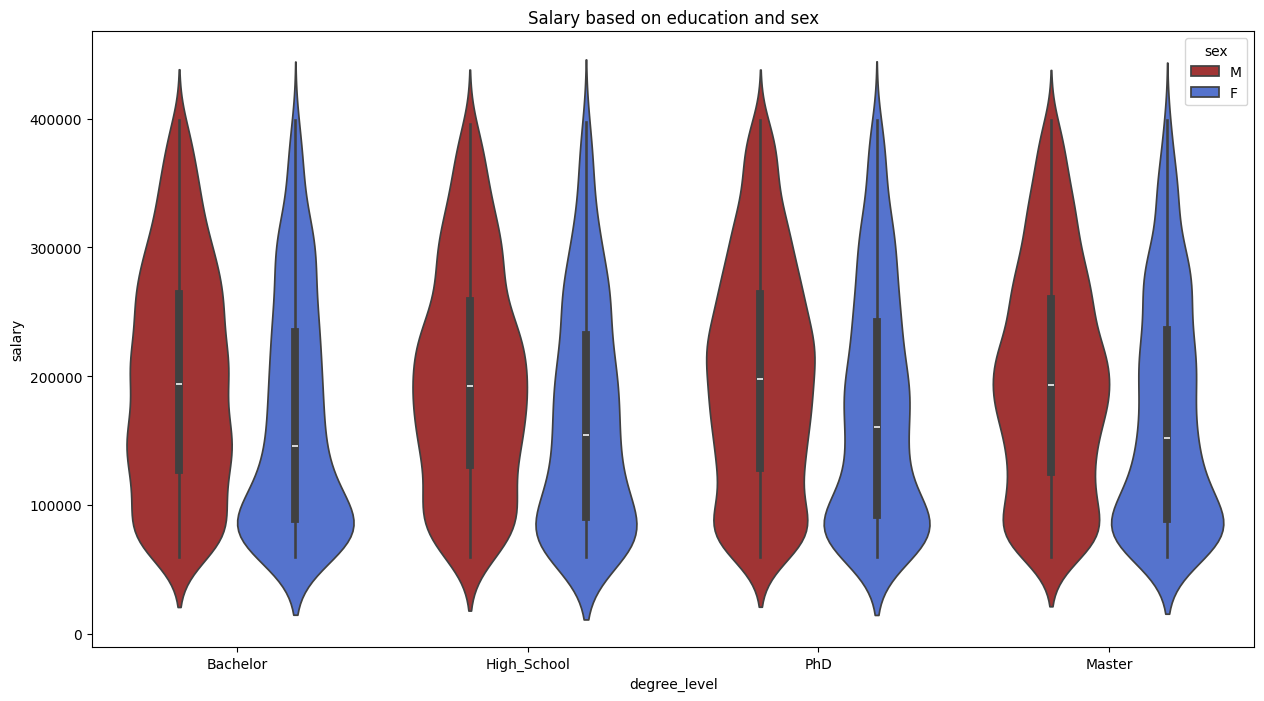

In [482]:
#violin graph to show overall salary for men versus women dependent on education
plt.figure(figsize=(15,8))
plt.title("Salary based on education and sex")
sns.violinplot(x ="degree_level", y ="salary", data = df_no, hue = 'sex', palette=color_palette)

according to this graph, women with the same degree as men, have a medium salary consistently lower than men. Men also had a wider variability in their salaries, over women which have a much stricter range. This still doesn't take into account years of experience and deptartment though. 

In [483]:
#Define the bins and labels for years of experience
bins = [0, 5, 10, 15, 20, float('inf')]  # 0-5, 6-10, 11-15, 16-20, 20+
labels = ['0-5', '6-10', '11-15', '16-20', '20+']  # Labels for each bin

#creating another dataframe for this graph
df_graph = df_no.copy()

# Create a new 'yrs_group' column by binning the 'yrs_experience' column
df_graph['yrs_group'] = pd.cut(df_graph['yrs_experience'], bins=bins, labels=labels, right=True)

#Group by 'sex' and 'age_group' and calculate the average salary
avg_salary_by_sex_yrs_group = df_graph.groupby(['yrs_group', 'sex'])['salary'].mean().unstack()

# Display the result
print(avg_salary_by_sex_yrs_group)

sex                    F              M
yrs_group                              
0-5        169515.398230  198414.131690
6-10       173532.231405  197694.362018
11-15      184881.720430  203452.380952
16-20      206444.444444  210219.512195
20+        251210.526316  256476.190476


C:\Users\brean\AppData\Local\Temp\ipykernel_7964\2489859627.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_salary_by_sex_yrs_group = df_graph.groupby(['yrs_group', 'sex'])['salary'].mean().unstack()


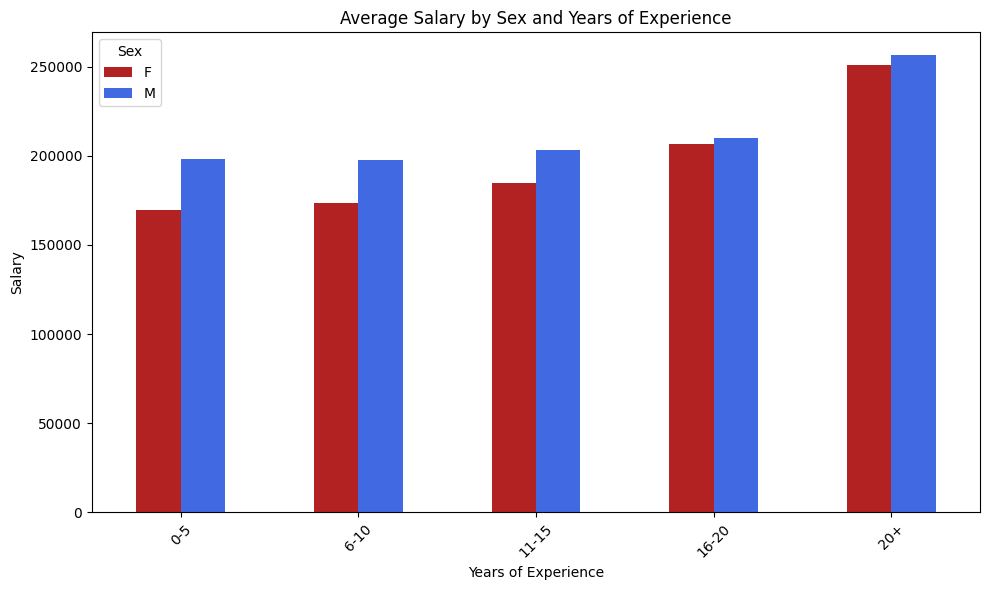

In [484]:
#Plot the average salary by sex and age group
avg_salary_by_sex_yrs_group.plot(kind='bar', figsize=(10, 6), color = color_palette)

# Customize the plot
plt.title('Average Salary by Sex and Years of Experience')
plt.xlabel('Years of Experience')
plt.ylabel('Salary')
plt.xticks(rotation=45)
plt.legend(title='Sex', loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()

So, according to the above graph, females, even with similar years of experiences, are getting paid less than their male counterparts. 

In [485]:
#making a copy for the below code
df2 = df_no.copy()

In [486]:
#finding out the exact dept names
print(df2['dept'].unique())

['sales' 'HR' 'engineering' 'marketing']


In [487]:
# Define mapping dictionaries
degree_mapping = {"High_School": 1, "Bachelor": 2, "Master": 3, "PhD": 4}
level_mapping = {"IC": 1, "MM": 2, "D": 3, "VP": 4, "E": 5, "CEO": 6}
dept_mapping = {"sales": 1, "HR": 2, "engineering": 3, "marketing": 4, "CEO": 5}

In [488]:
# Apply mappings
df2['degree_level'] = df2['degree_level'].replace(degree_mapping).infer_objects().astype(int)
df2['level'] = df2['level'].replace(level_mapping).infer_objects().astype(int)
df2['dept'] = df2['dept'].replace(dept_mapping).infer_objects().astype(int)

C:\Users\brean\AppData\Local\Temp\ipykernel_7964\4113799711.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df2['degree_level'] = df2['degree_level'].replace(degree_mapping).infer_objects().astype(int)
C:\Users\brean\AppData\Local\Temp\ipykernel_7964\4113799711.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df2['level'] = df2['level'].replace(level_mapping).infer_objects().astype(int)
C:\Users\brean\AppData\Local\Temp\ipykernel_7964\4113799711.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will b

In [489]:
# Convert 'sex' to numerical
df2['sex'] = (df2['sex'] == 'M').astype(int) 

# Display the first few rows of the modified DataFrame
print(df2.head())

   employee_id   boss_id  dept  signing_bonus    salary  degree_level  sex  \
0        46456  175361.0     1              0  213000.0             2    1   
1       104708   29733.0     2              0   79000.0             2    0   
2       120853   41991.0     1              0  199000.0             1    1   
3       142630  171266.0     2              0  143000.0             4    0   
4        72711  198240.0     1              0  235000.0             3    1   

   yrs_experience  level  total_reports  
0               5      1              0  
1               3      1              0  
2               5      1              0  
3              13      2             16  
4               1      1              0  


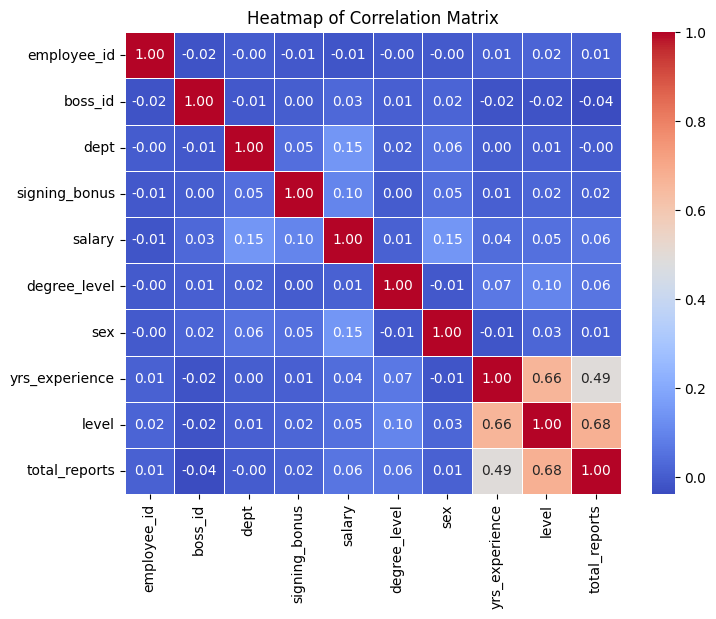

In [491]:
# Create a heatmap of the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(df2.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Heatmap of Correlation Matrix')
plt.show()

created a heatmap to see if there are any obvious correlations between the salary and the other factors and there does appear to be a correlation between dept, signing bonus, and sex. 

In [493]:
# Split data into features and target
x2 = df2.drop(columns=['salary'])  # Features
y2 = df2['salary']  # Target variable

In [494]:
# scale features
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x2)

In [495]:
# Apply feature selection using f_regression
selector = SelectKBest(f_regression, k=5)
selector.fit(x_scaled, y2)

SelectKBest(k=5, score_func=<function f_regression at 0x00000229BB8D7880>)

In [496]:
#select the specific columns
selected_columns = x2.columns[selector.get_support(indices=True)]

In [497]:
#get the scores
scores = selector.scores_

In [498]:
#combine the columns with their respective scores and print
top_5_features = sorted(zip(scores, selected_columns), reverse=True)[:3]

print("Top 5 features based on SelectKBest (f_regression):")
for score, feature in top_5_features:
    print(f"Feature: {feature}, Score: {score}")

Top 5 features based on SelectKBest (f_regression):
Feature: sex, Score: 219.1231565836608
Feature: level, Score: 106.81509145330942
Feature: signing_bonus, Score: 7.305399272352447


of all of the columns given, these ones are the most influential on your salary. sex is number one, level within the company is number two, your signing bonus is number three. This would make sense, because the larger your signing bonus, the larger the salary that you're being offered probably is. And the level that you are within the company is also important for salary. We're only looking at the top three because none of the other columns have a very insignificant score. 

In the above code I changed the categorical columns to numerical via a mappy system and I ran some testing on that. Now, I'm going to take the dataframe before these changes were done, and change the categorical columns to numerical using one hot coding to get more in depth data. 

In [499]:
#Identify numeric and categorical columns
numeric_columns = df_no.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_columns = df_no.select_dtypes(include=['object']).columns.tolist()


In [500]:
# Remove the target column 'salary' from the numeric section
numeric_columns.remove('salary') 

In [501]:
#Define the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        # Apply MinMax scaler to numeric columns
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),  # Handle missing values
            ('scaler', MinMaxScaler())  # Scale numeric features
        ]), numeric_columns),
        
        # Apply OneHotEncoder to categorical columns
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # Handle missing values
            ('onehot', OneHotEncoder(drop='first'))  # One-hot encode categorical features
        ]), categorical_columns)
    ])

In [502]:
# Apply SelectKBest for feature selection
select_k_best = SelectKBest(score_func=f_regression, k=5)  # Select top 5 features based on f_regression

In [503]:
#set up our pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', SelectKBest(score_func=f_regression, k=5))  # Apply feature selection after preprocessing
])

In [504]:
# Split data into features and target
x = df_no.drop(columns=['salary'])  # Features
y = df_no['salary']  # Target variable

In [505]:
# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [506]:
#Fit the pipeline on the training data
pipeline.fit(x_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['employee_id', 'boss_id',
                                                   'signing_bonus',
                                                   'yrs_experience',
                                                   'total_reports']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['dept', 'degree_level',
                                                   'sex', 'level'])])),
                ('feature_selection',
                 SelectKBest(k=5,
                             score_func=<function f_regression at 0x00000229BB8D7880>))])

In [507]:
# Extract the SelectKBest step from the pipeline
feature_selection = pipeline.named_steps['feature_selection']

In [508]:
# Get the feature scores from SelectKBest
feature_scores = feature_selection.scores_

In [509]:
# Get the mask of selected features
selected_features_mask = feature_selection.get_support()

In [510]:
#get one hot coded categorical columns
onehot_columns = preprocessor.transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_columns)

In [511]:
# Combine the column names (numeric columns + one-hot encoded categorical columns)
all_feature_names = np.concatenate([numeric_columns, onehot_columns])

In [512]:
# Get the names of the selected features based on the mask
selected_feature_names = all_feature_names[selected_features_mask]

In [513]:
# Sort the selected features by their score
top_5_features = sorted(zip(feature_scores, selected_feature_names), reverse=True)[:5]

# Print the top 5 features with their scores
print("Top 5 features based on SelectKBest:")
for score, feature in top_5_features:
    print(f"Feature: {feature}, Score: {score}")

Top 5 features based on SelectKBest:
Feature: dept_engineering, Score: 81.32240920702456
Feature: level_VP, Score: 32.868045732129644
Feature: sex_M, Score: 11.227488873927241
Feature: total_reports, Score: 3.7474539192177034
Feature: signing_bonus, Score: 1.3055562256307118


What we did in this code is set up one hot encoders for each categorical column. Meaning that the level column would turn into five individual columns since there are five options and an employee would be labeled a 0 or 1 based on which option they had in the original column. By doing this, we increased our number of columns and the top five features is now based on all of these newly created columns. Because of this, we have more in depth information on what specifically affects someone's salary. So, if someone is in the HR department (though this results in a lower salary; it still has a huge affect), if someone is male (we did also see in the graphs that this did cause a salary increase), if someone is in the engineering dept (which would cause a significant increase in salary), someone's total reports (the total number of people who they're in charge of), and their signing bonus. 

In [514]:
# Fit and transform the training data
x_train_transformed = pipeline.fit_transform(x_train, y_train)

In [515]:
# Apply the same transformations to the test data
x_test_transformed = pipeline.transform(x_test)

In [516]:
#trying the linear regression model
model_lr = LinearRegression()
model_lr.fit(x_train_transformed, y_train)

LinearRegression()

In [517]:
# Make predictions
y_pred = model_lr.predict(x_test_transformed)

In [519]:
# Evaluate the model 
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2 = r2_score(y_test, y_pred)
print(f"Accuracy: MAE={mae}, MSE={mse}, RMSE={rmse}, r2={r2} MAPE={mape}%")

Accuracy: MAE=69811.35165408989, MSE=6785847015.847125, RMSE=82376.25274220189, r2=0.13250136393389678 MAPE=50.18057130225376%


These are not good numbers for this model. The MAE is saying that the salary could be off by almost 70k when determining the salary for new employees, which is a large amount. THe large MSE means that there are going to be large errors in this model. and the MAPE is saying that the predictions could be off by 50%. and the r2 should be as close to 1 as possible and it's only 0.1. So, let's try a different one. 

In [520]:
#Trying the random forest regressor
rf = RandomForestRegressor(random_state=42)

# Define hyperparameters to tune
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Grid Search for Hyperparameter Tuning
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(x_train_transformed, y_train)

# Print the best parameters
print("Best Hyperparameters:", grid_search.best_params_)

# Use the best model to predict
best_rf_model = grid_search.best_estimator_
y_pred = best_rf_model.predict(x_test_transformed)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Best Model MSE: {mse:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")


Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Best Model MSE: 6853484801.6159, RMSE: 82785.7766, R²: 0.1239


Unfortunately, these numbers still aren't very good. I'm going to run a method to test many models at once and see which one is the most accurate. 

In [521]:
#a list of models to try
models = {
    'Logistic Regression': LogisticRegression(max_iter=200),
    'Random Forest': RandomForestClassifier(),
    'Random Forest Regressor': RandomForestRegressor(n_estimators=100, random_state=42),
    'Support Vector Machine': SVC(),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier()
}


In [522]:
# Store results of each model
results = {}

In [523]:
#for each model, fit them to the data, and then run the predictions. 
for name, model in models.items():
    model.fit(x_train_transformed, y_train)
    
    y_pred = model.predict(x_test_transformed)
    
    
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {
        'mse': mse,
        'mae': mae,
        'rmse': rmse,
        'mape': mape,
        'r2': r2
    }

In [524]:
#print all of the data from each model
print("Performance metrics for each model:")
for model_name, metrics in results.items():
    print(f"\n{model_name}:")
    for metric, value in metrics.items():
        if metric == "Confusion Matrix":
            print(f"  {metric}:\n  {value}")
        else:
            print(f"  {metric}: {value:.4f}")

Performance metrics for each model:

Logistic Regression:
  mse: 15114272136.0680
  mae: 97459.7299
  rmse: 122940.1161
  mape: 56.5754
  r2: -0.9322

Random Forest:
  mse: 14510734367.1836
  mae: 94821.4107
  rmse: 120460.5096
  mape: 52.9367
  r2: -0.8550

Random Forest Regressor:
  mse: 6965752346.4735
  mae: 70422.6217
  rmse: 83461.0828
  mape: 50.2240
  r2: 0.1095

Support Vector Machine:
  mse: 13742185092.5463
  mae: 92204.1021
  rmse: 117227.0664
  mape: 52.0764
  r2: -0.7568

Gradient Boosting:
  mse: 6826555619.4853
  mae: 69931.4519
  rmse: 82622.9727
  mape: 50.0903
  r2: 0.1273

K-Nearest Neighbors:
  mse: 18471955477.7389
  mae: 109949.4747
  rmse: 135911.5723
  mape: 51.0083
  r2: -1.3614

Naive Bayes:
  mse: 35050421210.6053
  mae: 166825.4127
  rmse: 187217.5772
  mape: 137.5228
  r2: -3.4808

Decision Tree:
  mse: 13648695847.9240
  mae: 92262.6313
  rmse: 116827.6331
  mape: 49.2599
  r2: -0.7448


In [525]:
# Find the best model based on the r2
best_model_name = max(results, key=lambda x: results[x]['r2'])
best_model_accuracy = results[best_model_name]['r2']

In [526]:
#print the r2 for the best model
print(f"\nThe best model is {best_model_name} with an mse of {best_model_accuracy:.4f}")


The best model is Gradient Boosting with an mse of 0.1273


According to all of these models, the first one, linear regression, with an r2 of 0.13 is the best fit. I tried the standard scaler and the numbers were much better with the MinMax Scaler but these are still far from good numbers. 

In [ ]:
# Predict salary for a new employee
new_employee = pd.DataFrame({
    'department': ['IT'],
    'years_of_experience': [6],
    'education_level': ['Master\'s'],
    'gender': ['Male'],
    'age': [32]
})

predicted_salary = model_pipeline.predict(new_employee)
print(f'Predicted Salary for new employee: {predicted_salary[0]}')